# Project 4: Naver movie sentiment classification


- Rubric

1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.	3가지 이상의 모델이 성공적으로 시도됨
2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.	gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함
3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.	네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

## Version check

In [1]:
import pandas as pd
import konlpy
import gensim

print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


## 1) Data check

In [2]:
# Read data

train_data = pd.read_table('./data/ratings_train.txt')
test_data = pd.read_table('./data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
train_data.info() # there are 5 nulls on document column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


## 2) Create data loader
* What it should contain
 #### data pre-pre-process part
 
    - 데이터의 중복 제거
    - NaN 결측치 제거
    - 한국어 토크나이저로 토큰화
    - 불용어(Stopwords) 제거
    
 #### string to dictionary part
 
    - 사전word_to_index 구성
    - 텍스트 스트링을 사전 인덱스 스트링으로 변환
    - X_train, y_train, X_test, y_test, word_to_index 리턴

In [4]:
# tools for tokenizer and stopwords
from collections import Counter
from konlpy.tag import Mecab
import numpy as np

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [5]:
# data pre-pre-process part

def process_data(data):
    data.drop_duplicates(subset=['document'], inplace=True)  # 데이터 중복 제거
    data = data.dropna(how = 'any')  # NaN 결측치 제거
    processed_data = []   
    for comment in data['document']:      # for each comments,
        tokenized_comment = tokenizer.morphs(comment)  # 한국어 토크나이저로 토큰화
        tokenized_comment = [token for token in tokenized_comment if not token in stopwords]  # 불용어(Stopwords) 제거
        processed_data.append(tokenized_comment)   # gather processed data
    return processed_data, np.array(list(data['label']))     # return words & target


# string to dictionary part & load

def load_data(train_data, test_data, num_words=10000):
    
    X_train, y_train = process_data(train_data)   # train data 전처리
    X_test, y_test = process_data(test_data)      # test data 전처리
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4) # 가장 빈번한 단어 계산 + 특수 단어 4개 제외
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):    # 사전word_to_index 구성
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]  #unknown으로 반환
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, y_train, X_test, y_test, word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [6]:
 # X_train : type -list, y_train : type - np.array

print(len(X_train), len(X_test)) 
print(len(y_train), len(y_test))
print(list(word_to_index.items())[:10]) # stopwords에 '다','하','을'이 없어서 살아남은걸 볼 수 있다

146182 49157
146182 49157
[('<PAD>', 0), ('<BOS>', 1), ('<UNK>', 2), ('<UNUSED>', 3), ('.', 4), ('영화', 5), ('다', 6), ('고', 7), ('하', 8), ('을', 9)]


## Word-index dict -> index-Word dict

In [7]:
# key - contents 의 역전
index_to_word = {index:word for word, index in word_to_index.items()}

print(list(index_to_word.items())[:10]) 

[(0, '<PAD>'), (1, '<BOS>'), (2, '<UNK>'), (3, '<UNUSED>'), (4, '.'), (5, '영화'), (6, '다'), (7, '고'), (8, '하'), (9, '을')]


## Encoding & Decoding functions for comments

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) Data analysis and engineering

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

max number of words:  116
[(7, 12441), (8, 11822), (6, 11741), (9, 10907), (10, 10287), (5, 9580), (11, 9531), (12, 8928), (13, 8253), (14, 7868), (15, 7440), (4, 6936), (16, 6823), (17, 6258), (18, 5535), (3, 4951), (19, 4869), (20, 4312), (21, 3746), (22, 3136), (23, 2653), (2, 2554), (24, 2242), (25, 1993), (26, 1688), (27, 1512), (28, 1376), (29, 1270), (30, 1241), (31, 1108), (32, 1074), (1, 1015), (34, 951), (33, 947), (35, 927), (37, 854), (36, 814), (38, 763), (40, 728), (39, 714)]


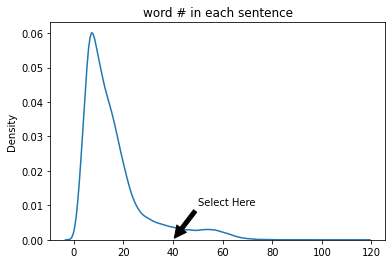

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

total_list = X_train + X_test
words_in_X = [len(s) for s in total_list]
print('max number of words: ', max(words_in_X))
print(Counter(words_in_X).most_common(40))

plt.title('word # in each sentence')
sns.kdeplot(data= words_in_X)
plt.annotate('Select Here', xy=(40, 0), xytext=(50, 0.01), arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()


- max token selection : 40

In [10]:
max_tokens = 40

### Set sentences into length of max_tokens

In [11]:
# 최대길이(max_tokens)에 맞춰서 긴 문장은 잘라내고, 부족한 것은 앞에 공백 덭대기
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, value=word_to_index["<PAD>"], padding='pre', maxlen=max_tokens)

X_test = pad_sequences(X_test, value=word_to_index["<PAD>"], padding='pre', maxlen=max_tokens)

print(X_train.shape)
print(type(X_train))
print(X_train[:10])
# 'pre' 에 pad를 덭대는 이유는 rnn계열의 신경망은 나중에 들어오는 
# input에 대해서 강하게 영향 받기 때문

(146182, 40)
<class 'numpy.ndarray'>
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0   32   74  919    4    4   39  228   20   33  748]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0 1028    4   11  519  549
   687    5  120    4   70 1639   52  925 1006   15   44  391]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0   24  205    2]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0 8409
   158 3925    4    4  298   94   17    6    4    4   58 3479]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    2 8894 1108   52 2832   60    5   14 2758  

## 4) 모델 구성 및 validation set 구성



In [12]:
vocab_size = 10000       # 단어 주머니 10000개
word_vector_dim = 50     # 각 토큰별 특성 갯수

### 1. RNN model (LSTM)

In [13]:
import tensorflow as tf

class RNN(tf.keras.Model):
    def __init__(self):
        super(RNN, self).__init__()
        
        self.embedding_layer = tf.keras.layers.Embedding(vocab_size, word_vector_dim)
        self.lstm_layer = tf.keras.layers.LSTM(8)
        self.dense_layer1 = tf.keras.layers.Dense(8, activation='relu')
        self.dense_layer2 = tf.keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, inputs):
        x = self.embedding_layer(inputs)
        x = self.lstm_layer(x)
        x = self.dense_layer1(x)
        x = self.dense_layer2(x)
        return x

### 2. 1-D CNN model

In [14]:
class CNN(tf.keras.Model):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.embedding_layer = tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))
        self.conv1d_layer1 = tf.keras.layers.Conv1D(16, 6, strides=1, activation='relu')
        self.maxpooling1d_layer = tf.keras.layers.MaxPooling1D(5)
        self.conv1d_layer2 = tf.keras.layers.Conv1D(32, 6, strides=1, activation='relu')
        self.globalmaxpooling1d_layer = tf.keras.layers.GlobalMaxPooling1D()
        self.dense_layer1 = tf.keras.layers.Dense(32, activation='relu')
        self.dense_layer2 = tf.keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, inputs):
        x = self.embedding_layer(inputs)
        x = self.conv1d_layer1(x)
        x = self.maxpooling1d_layer(x)
        x = self.conv1d_layer2(x)
        x = self.globalmaxpooling1d_layer(x)
        x = self.dense_layer1(x)
        x = self.dense_layer2(x)
        return x

### 3. GlobalMaxPooling1D

In [15]:
class GlobalMaxPooling(tf.keras.Model):
    def __init__(self):
        super(GlobalMaxPooling, self).__init__()
        
        self.embedding_layer = tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))
        self.globalmaxpooling1d_layer = tf.keras.layers.GlobalMaxPooling1D()
        self.dense_layer1 = tf.keras.layers.Dense(8, activation='relu')
        self.dense_layer2 = tf.keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, inputs):
        x = self.embedding_layer(inputs)
        x = self.globalmaxpooling1d_layer(x)
        x = self.dense_layer1(x)
        x = self.dense_layer2(x)
        return x

### Validation set 구성
훈련용 데이터셋 25000건 중 10000건을 분리하여 검증셋(validation set)으로 사용

In [16]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 40)
(136182,)


## 5) 모델 훈련 개시

In [17]:
RNN_model = RNN()
CNN_model = CNN()
GlobalMaxPooling_model = GlobalMaxPooling()

models = [RNN_model, CNN_model, GlobalMaxPooling_model]  # 모델 다발 생성

for model in models:
    model.build(input_shape=(512, 40))  # input_shape (batch size, token length)
    model.summary()

Model: "rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  500000    
_________________________________________________________________
lstm (LSTM)                  multiple                  1888      
_________________________________________________________________
dense (Dense)                multiple                  72        
_________________________________________________________________
dense_1 (Dense)              multiple                  9         
Total params: 501,969
Trainable params: 501,969
Non-trainable params: 0
_________________________________________________________________
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  500000    
____________________________________________

In [18]:
epochs=20
rnn_history = None
cnn_history = None
max_history = None
for model in models:
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(partial_X_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val, y_val), verbose=1)
    if model == RNN_model:
        rnn_history = history.history.copy()
    elif model == CNN_model:
        cnn_history = history.history.copy()
    else:
        max_history = history.history.copy()

Epoch 1/20
266/266 [==============================] - 35s 7ms/step - loss: 0.4761 - accuracy: 0.7858 - val_loss: 0.3573 - val_accuracy: 0.8441
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3334 - accuracy: 0.8599 - val_loss: 0.3412 - val_accuracy: 0.8523
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3105 - accuracy: 0.8702 - val_loss: 0.3361 - val_accuracy: 0.8518
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2962 - accuracy: 0.8771 - val_loss: 0.3347 - val_accuracy: 0.8562
Epoch 5/20
266/266 [==============================] - 1s 6ms/step - loss: 0.2833 - accuracy: 0.8836 - val_loss: 0.3350 - val_accuracy: 0.8561
Epoch 6/20
266/266 [==============================] - 1s 6ms/step - loss: 0.2699 - accuracy: 0.8900 - val_loss: 0.3403 - val_accuracy: 0.8545
Epoch 7/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2568 - accuracy: 0.8956 - val_loss: 0.3432 - val_accuracy: 0.8544
Epoch

266/266 [==============================] - 1s 4ms/step - loss: 0.0493 - accuracy: 0.9868 - val_loss: 0.6956 - val_accuracy: 0.8238
Epoch 19/20
266/266 [==============================] - 1s 4ms/step - loss: 0.0435 - accuracy: 0.9880 - val_loss: 0.7273 - val_accuracy: 0.8247
Epoch 20/20
266/266 [==============================] - 1s 4ms/step - loss: 0.0384 - accuracy: 0.9898 - val_loss: 0.7622 - val_accuracy: 0.8217


### 각 모델에 대한 평가 (evaluation)

In [19]:
loss = []
accuracy = []
i = 0

for model in models:
    results = model.evaluate(X_test, y_test, verbose=2)
    loss.append(results[0])
    accuracy.append(results[1])

acc_per = np.array(accuracy) * 100

for model in models:
    model_name = type(model).__name__
    print(f"{model_name}의 loss는 {loss[i]:.4f}, accuracy는 {acc_per[i]:.2f}%")
    i += 1

1537/1537 - 3s - loss: 0.5497 - accuracy: 0.8374
1537/1537 - 3s - loss: 1.2616 - accuracy: 0.8217
1537/1537 - 2s - loss: 0.7712 - accuracy: 0.8215
RNN의 loss는 0.5497, accuracy는 83.74%
CNN의 loss는 1.2616, accuracy는 82.17%
GlobalMaxPooling의 loss는 0.7712, accuracy는 82.15%


- RNN(LSTM) loss는 0.6051, accuracy는 83.97%
- CNN(1-D) loss는 1.2218, accuracy는 82.23%
- GlobalMaxPooling(1-D)의 loss는 0.7823, accuracy는 82.18%

accuracy < 85% (need better model), or need to change parameters

## 6) Loss, Accuracy 그래프 시각화

In [20]:
histories = [rnn_history, cnn_history, max_history]

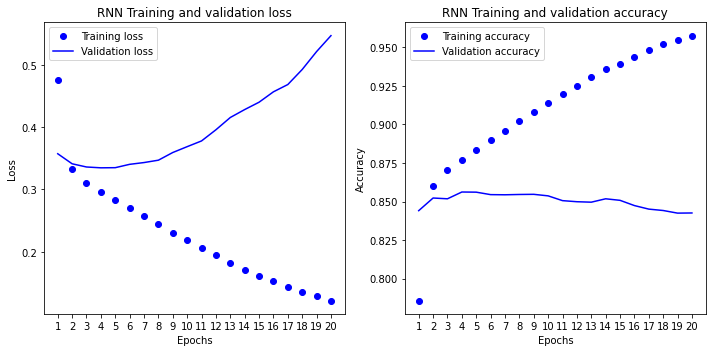

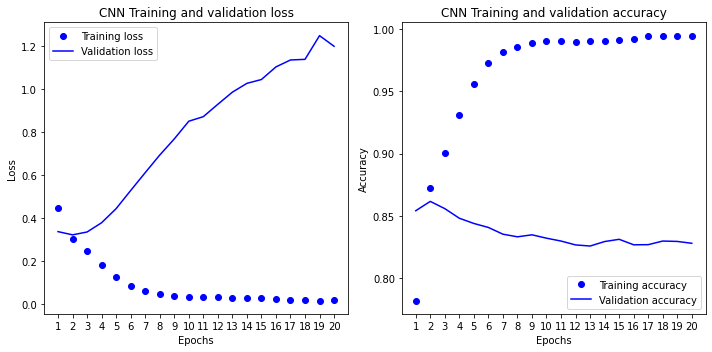

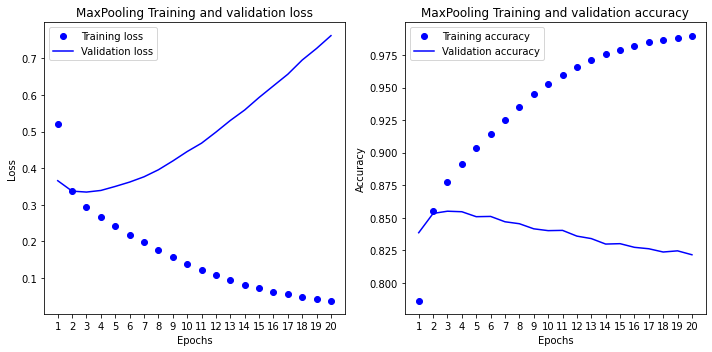

In [21]:
titles = ['RNN', 'CNN', 'MaxPooling']
for i, history in enumerate(histories):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)

     # 그래프 크기를 조절
    plt.figure(figsize=(10, 5))

    
    plt.subplot(1, 2, 1)
    # "bo" 파란점
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # "b" 파란선
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(titles[i] + ' Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(1, len(epochs) + 1))  # 에포크를 정수로 표시
    plt.legend()

    plt.subplot(1, 2, 2)
    # "bo" 파란점
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    # "b" 파란선
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(titles[i] + ' Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, len(epochs) + 1))  # 에포크를 정수로 표시
    plt.legend()

    plt.tight_layout()
    plt.show()


이미 epoch 2~3 쯤에서 train과 validation이 이별하고 있다, 괴리가 커지고 있다, overfitting 되고 있다

초기(epoch 2~3)에 높은 성능을 보여주다가 성능이 떨어지고 있다 -> 3 epoch만 해보고 성능 파악 필요

## 7) 학습된 Embedding 레이어 분석

In [22]:
for model in models:
    embedding_layer = model.layers[0]
    weights = embedding_layer.get_weights()[0]
    model_name = type(model).__name__
    print('embedding layer', model_name , ': ',weights.shape)

embedding layer RNN :  (10000, 50)
embedding layer CNN :  (10000, 50)
embedding layer GlobalMaxPooling :  (10000, 50)


In [23]:
def save_embedding_parameters(models, titles, index_to_word, vocab_size, word_vector_dim):
    for i, model in enumerate(models):
        # 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
        word2vec_file_path = f'./data/word2vec_{titles[i]}.txt'
        f = open(word2vec_file_path, 'w')
        f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

        # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
        vectors = model.get_weights()[0]
        for i in range(4, vocab_size):
            f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
        f.close()
        
save_embedding_parameters(models, titles, index_to_word, vocab_size, word_vector_dim)

In [24]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 각 모델들이 생각하는 '꿈'과 근접한 단어들 찾기
for title in titles:
    word2vec_file_path = f'./data/word2vec_{title}.txt'
    word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
    print(title, '<- 꿈')  
    print(word_vectors.similar_by_word("꿈"))

RNN <- 꿈
[('아플', 0.8621363639831543), ('결정판', 0.8605970144271851), ('조직', 0.8495230674743652), ('얽힌', 0.8489258885383606), ('십쇼', 0.8487423658370972), ('비장', 0.8480411767959595), ('전두환', 0.8463990688323975), ('대표작', 0.8458964824676514), ('과자', 0.839668333530426), ('on', 0.8337781429290771)]
CNN <- 꿈
[('엉엉', 0.6910938024520874), ('!!!!!!!!!!', 0.678537130355835), ('느껴져서', 0.6593318581581116), ('탔', 0.64991295337677), ('~~~^^', 0.6471527218818665), ('통찰', 0.6401941776275635), ('채워', 0.6354902982711792), ('개꿀', 0.6334583163261414), ('고정', 0.628620982170105), ('..♥', 0.62813401222229)]
MaxPooling <- 꿈
[('베티', 0.7224622964859009), ('용감', 0.6940117478370667), ('트', 0.6931111216545105), ('우정', 0.6897616386413574), ('로맨스', 0.6882113218307495), ('그때', 0.687092661857605), ('애잔', 0.6858820915222168), ('엄청나', 0.6847228407859802), ('ost', 0.682385265827179), ('엑스맨', 0.6778723001480103)]


- 통일성, 유사성이 떨어진다는것을 확인

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선


In [25]:
from gensim.models import Word2Vec

word2vec_file_path = './data/word2vec_ko.model'

word_vectors = Word2Vec.load(word2vec_file_path)  # pretrained embedding model load
print('pretrained embedding layer <- 꿈 \n',word_vectors.wv.similar_by_word("꿈"))

pretrained embedding layer <- 꿈 
 [('인생', 0.7489830255508423), ('추억', 0.7478811144828796), ('악몽', 0.7333221435546875), ('운명', 0.7141579389572144), ('사랑', 0.7089294195175171), ('삶', 0.7056183815002441), ('세상', 0.7003714442253113), ('기쁨', 0.6934624910354614), ('마음', 0.6885642409324646), ('행복', 0.6853602528572083)]


In [26]:
vector = word_vectors.wv['꿈']
vector.shape 

# 각 단어는 100개의 차원으로 vectorize 됨을 확인

(100,)

In [27]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수 
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [28]:
embedding_matrix.shape         

(10000, 100)

In [29]:
print(index_to_word[4], '\n' ,embedding_matrix[4])    # '.' 이 벡터로 변한 형태

. 
 [ 1.0148797  -0.50785506 -3.01209021  0.45532331  1.18936408  1.16196549
  2.0690465  -0.4041273  -3.67824864  5.15002871 -4.90728283 -1.17444587
 -2.04329658 -0.27965945 -3.60060024  3.71831751  1.4845506   0.3471984
  3.05809855 -2.98130846 -2.75871563  1.69519937 -0.62313354 -2.48172998
  1.7739619   0.90663171  3.50179338 -4.62058544 -2.70127892  0.75214028
 -6.49481773  3.31358528  0.79373801  3.56094408  0.5049091   2.51798296
  1.08281338  2.22650957 -0.54819411 -2.45683312  5.82740164 -0.48938593
  7.21801424 -0.25775084 -0.69435704 -0.57397074 -0.9460867   3.64878941
 -0.61506265 -4.03338385  0.41044739 -0.03049513  0.09765369 -5.68309593
  1.61000216  1.61402714 -0.35847089  0.99730688  1.03616691 -3.59692454
  0.92260575  0.27273268  1.30361199 -0.35995319 -2.94048095 -1.03001702
  3.20227623 -5.205935    2.38758183 -3.1253984   1.00584948 -1.81666231
  4.36685753 -4.05125952 -0.36159644 -0.69638383  1.12456954 -0.62755346
  0.2120384  -4.40245962 -2.05257916 -3.70964599

In [30]:
print(index_to_word[5], '\n' ,embedding_matrix[5])    # '영화' 가 벡터로 변한 형태

영화 
 [-1.80073893 -1.1790098  -2.4066596   2.13841558 -0.3537603   1.37495267
 -4.89461184 -3.65171981  0.44114441  0.78153926 -2.69688797 -1.78128517
 -2.15146542 -4.81323624  2.74659181 -2.16203237 -0.11467794 -1.24311709
  2.39793086 -1.10606277 -0.41043055  1.95003915  0.7821002   1.58999777
  1.6447444  -2.12650347 -1.79815948  1.7535795   0.53717697 -1.21212101
 -4.46631622  4.54883242  1.33444095 -0.90702713  1.19318891  4.15632153
  1.97583067 -0.94375622 -0.25927249  0.34935686  1.85628748 -3.32496452
  1.12216246  1.28365242  3.92113757  3.8023994   2.76626897  0.67293745
  2.28536439 -5.11317158  0.32525915 -3.3079958   5.30435133 -3.88137579
 -0.32960036 -1.95275044  3.88650751 -3.54703784 -0.21991685  0.82119733
 -0.94924921  3.54721069  1.32204795 -0.70640826  0.52253807  1.46832347
 -1.10186887  2.26294088 -0.72046852 -1.76620102  5.22375774  3.0748682
  1.09775758  3.31917334 -0.41004229 -1.7022891  -0.78379875  0.82586575
 -0.54520637  1.23553824  2.02674007 -0.6524469

In [31]:
#RNN에 사전 훈련된 embedding layer 적용
RNN_with_embedding = RNN()


RNN_with_embedding.build(input_shape=(512, 40))  # input_shape (batch size, token length)
RNN_with_embedding.summary()
RNN_with_embedding.embedding_layer.set_weights([embedding_matrix])
# 임베딩 레이어를 학습 불가능 상태로 설정합니다
RNN_with_embedding.embedding_layer.trainable = False


#CNN에 사전 훈련된 embedding layer 적용
CNN_with_embedding = CNN()

CNN_with_embedding.build(input_shape=(512, 40))  # input_shape (batch size, token length)
CNN_with_embedding.summary()
CNN_with_embedding.embedding_layer.set_weights([embedding_matrix])
# 임베딩 레이어를 학습 불가능 상태로 설정합니다
CNN_with_embedding.embedding_layer.trainable = False


#GlobalMaxPooling에 사전 훈련된 embedding layer 적용
Maxpooling_with_embedding = GlobalMaxPooling()

Maxpooling_with_embedding.build(input_shape=(512, 40))  # input_shape (batch size, token length)
Maxpooling_with_embedding.summary()
# 사전 훈련된 임베딩을 임베딩 레이어에 적용합니다
Maxpooling_with_embedding.embedding_layer.set_weights([embedding_matrix])
# 임베딩 레이어를 학습 불가능 상태로 설정합니다
Maxpooling_with_embedding.embedding_layer.trainable = False


Model: "rnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      multiple                  1000000   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  3488      
_________________________________________________________________
dense_6 (Dense)              multiple                  72        
_________________________________________________________________
dense_7 (Dense)              multiple                  9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________
Model: "cnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      multiple                  1000000   
____________________________________

In [32]:
embedded_models = [RNN_with_embedding, CNN_with_embedding, Maxpooling_with_embedding]

epochs=40 
e_rnn_history = None
e_cnn_history = None
e_max_history = None

for model in embedded_models:
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(partial_X_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val, y_val), verbose=1)
    if model == RNN_with_embedding:
        e_rnn_history = history.history.copy()
    elif model == CNN_with_embedding:
        e_cnn_history = history.history.copy()
    else:
        e_max_history = history.history.copy()

Epoch 1/40
266/266 [==============================] - 3s 6ms/step - loss: 0.6231 - accuracy: 0.6472 - val_loss: 0.5377 - val_accuracy: 0.7353
Epoch 2/40
266/266 [==============================] - 1s 5ms/step - loss: 0.5092 - accuracy: 0.7548 - val_loss: 0.4863 - val_accuracy: 0.7698
Epoch 3/40
266/266 [==============================] - 1s 5ms/step - loss: 0.4785 - accuracy: 0.7748 - val_loss: 0.4693 - val_accuracy: 0.7800
Epoch 4/40
266/266 [==============================] - 1s 5ms/step - loss: 0.4625 - accuracy: 0.7840 - val_loss: 0.4531 - val_accuracy: 0.7891
Epoch 5/40
266/266 [==============================] - 1s 5ms/step - loss: 0.4496 - accuracy: 0.7922 - val_loss: 0.4470 - val_accuracy: 0.7917
Epoch 6/40
266/266 [==============================] - 1s 4ms/step - loss: 0.4398 - accuracy: 0.7977 - val_loss: 0.4402 - val_accuracy: 0.7961
Epoch 7/40
266/266 [==============================] - 1s 4ms/step - loss: 0.4334 - accuracy: 0.8011 - val_loss: 0.4347 - val_accuracy: 0.8000
Epoch 

266/266 [==============================] - 1s 4ms/step - loss: 0.3656 - accuracy: 0.8337 - val_loss: 0.4449 - val_accuracy: 0.7948
Epoch 19/40
266/266 [==============================] - 1s 4ms/step - loss: 0.3639 - accuracy: 0.8349 - val_loss: 0.4445 - val_accuracy: 0.7952
Epoch 20/40
266/266 [==============================] - 1s 4ms/step - loss: 0.3629 - accuracy: 0.8347 - val_loss: 0.4493 - val_accuracy: 0.7915
Epoch 21/40
266/266 [==============================] - 1s 4ms/step - loss: 0.3592 - accuracy: 0.8382 - val_loss: 0.4492 - val_accuracy: 0.7972
Epoch 22/40
266/266 [==============================] - 1s 4ms/step - loss: 0.3571 - accuracy: 0.8389 - val_loss: 0.4499 - val_accuracy: 0.7981
Epoch 23/40
266/266 [==============================] - 1s 4ms/step - loss: 0.3556 - accuracy: 0.8397 - val_loss: 0.4501 - val_accuracy: 0.7973
Epoch 24/40
266/266 [==============================] - 1s 4ms/step - loss: 0.3553 - accuracy: 0.8399 - val_loss: 0.4501 - val_accuracy: 0.7960
Epoch 25/40

266/266 [==============================] - 1s 2ms/step - loss: 0.5942 - accuracy: 0.6803 - val_loss: 0.6023 - val_accuracy: 0.6777
Epoch 36/40
266/266 [==============================] - 1s 3ms/step - loss: 0.5943 - accuracy: 0.6799 - val_loss: 0.6007 - val_accuracy: 0.6801
Epoch 37/40
266/266 [==============================] - 1s 2ms/step - loss: 0.5941 - accuracy: 0.6804 - val_loss: 0.6007 - val_accuracy: 0.6762
Epoch 38/40
266/266 [==============================] - 1s 2ms/step - loss: 0.5935 - accuracy: 0.6809 - val_loss: 0.6021 - val_accuracy: 0.6748
Epoch 39/40
266/266 [==============================] - 1s 3ms/step - loss: 0.5936 - accuracy: 0.6805 - val_loss: 0.6010 - val_accuracy: 0.6793
Epoch 40/40
266/266 [==============================] - 1s 2ms/step - loss: 0.5931 - accuracy: 0.6810 - val_loss: 0.6041 - val_accuracy: 0.6740


In [33]:
loss = []
accuracy = []
i = 0

for model in embedded_models:
    results = model.evaluate(X_test, y_test, verbose=2)
    loss.append(results[0])
    accuracy.append(results[1])

acc_per = np.array(accuracy) * 100

for model in embedded_models:
    model_name = type(model).__name__
    print(f"embedded {model_name}의 loss는 {loss[i]:.4f}, accuracy는 {acc_per[i]:.2f}%")
    i += 1

1537/1537 - 3s - loss: 0.4031 - accuracy: 0.8177
1537/1537 - 3s - loss: 0.4897 - accuracy: 0.7866
1537/1537 - 2s - loss: 0.5980 - accuracy: 0.6754
embedded RNN의 loss는 0.4031, accuracy는 81.77%
embedded CNN의 loss는 0.4897, accuracy는 78.66%
embedded GlobalMaxPooling의 loss는 0.5980, accuracy는 67.54%


임베딩을 하고나서 오히려 동일조건 대비 40에포크 까지에서도 정확도가 모든 모델에서 떨어졌다

validation을 확인해 봐야겠다

In [34]:
e_histories = [e_rnn_history, e_cnn_history, e_max_history]

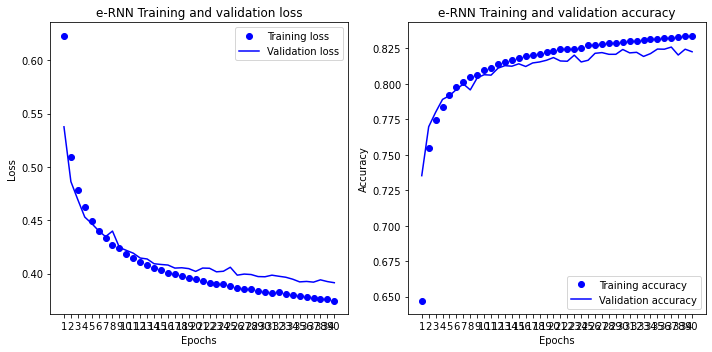

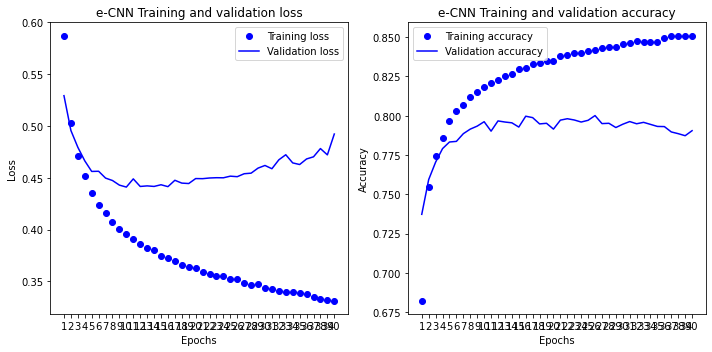

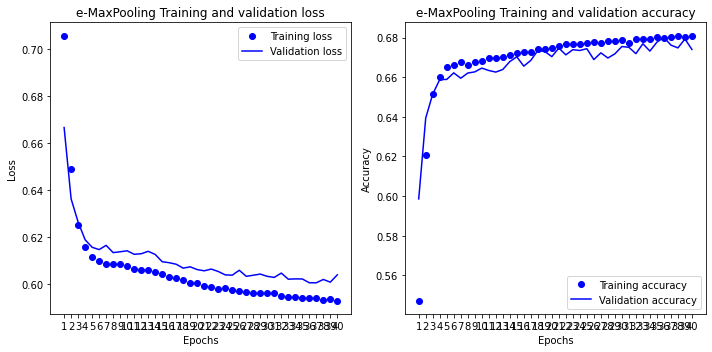

In [35]:
e_titles = ['e-RNN', 'e-CNN', 'e-MaxPooling']
for i, history in enumerate(e_histories):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)

     # 그래프 크기를 조절
    plt.figure(figsize=(10, 5))

    
    plt.subplot(1, 2, 1)
    # "bo" 파란점
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # "b" 파란선
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(e_titles[i] + ' Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(1, len(epochs) + 1))  # 에포크를 정수로 표시
    plt.legend()

    plt.subplot(1, 2, 2)
    # "bo" 파란점
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    # "b" 파란선
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(e_titles[i] + ' Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, len(epochs) + 1))  # 에포크를 정수로 표시
    plt.legend()

    plt.tight_layout()
    plt.show()

embedded layer가 포함된 RNN과 GlobalMaxpooling 모델은 validation 이 train 을 잘 따라왔다. 

- 하지만 epoch가 커짐에 따라 overfitting 되지 않는다 뿐이지 성능은 가장 잘 학습된 'e-RNN'(RNN with pretrained embedded layer' 기준으로도 83%에 못 미치는 성능을 보였다.

- 생각해볼점: embedded layer의 값이 변하지 않도록 강제하는 행위가 학습률을 떨어뜨린것 같은데, 이렇게 함으로써 train data나 test data나 pre-trained model의 validation set처럼 작용했던것이 아닐까, 혹은 저 pre-trained layer가 생성 될때는 복잡한 후반 과정이 있었는데, 내 모델은 그에 못 미치는 복잡도를 갖고 있기 때문에 모델이 pre-trained layer의 깊은 뜻(예를들면, 단어의 유사도)을 이해하지 못하는 것이 아닌가 싶은 생각이 든다.

## ※ 가장 validation accuracy가 높았던 상황을 재현하고 성능을 알아보자

### (1) vanila models with 2 epochs

In [36]:
epochs=2     

RNN_model_2 = RNN()
CNN_model_2 = CNN()
GlobalMaxPooling_model_2 = GlobalMaxPooling()

models_2 = [RNN_model_2, CNN_model_2, GlobalMaxPooling_model_2]  # 모델 다발 생성

loss = []
accuracy = []
i = 0

for model in models_2:
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(partial_X_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val, y_val), verbose=1)
    results = model.evaluate(X_test, y_test, verbose=2)
    loss.append(results[0])
    accuracy.append(results[1])

acc_per = np.array(accuracy) * 100

for model in models_2:
    model_name = type(model).__name__
    print(f"{model_name}_with_2_epochs의 loss는 {loss[i]:.4f}, accuracy는 {acc_per[i]:.2f}%")
    i += 1

Epoch 1/2
266/266 [==============================] - 3s 8ms/step - loss: 0.4492 - accuracy: 0.8056 - val_loss: 0.3420 - val_accuracy: 0.8514
Epoch 2/2
266/266 [==============================] - 2s 6ms/step - loss: 0.3250 - accuracy: 0.8623 - val_loss: 0.3340 - val_accuracy: 0.8547
1537/1537 - 3s - loss: 0.3515 - accuracy: 0.8485
Epoch 1/2
266/266 [==============================] - 2s 6ms/step - loss: 0.4316 - accuracy: 0.7951 - val_loss: 0.3329 - val_accuracy: 0.8546
Epoch 2/2
266/266 [==============================] - 1s 5ms/step - loss: 0.2948 - accuracy: 0.8769 - val_loss: 0.3167 - val_accuracy: 0.8617
1537/1537 - 3s - loss: 0.3320 - accuracy: 0.8581
Epoch 1/2
266/266 [==============================] - 2s 4ms/step - loss: 0.4755 - accuracy: 0.8029 - val_loss: 0.3456 - val_accuracy: 0.8484
Epoch 2/2
266/266 [==============================] - 1s 4ms/step - loss: 0.3175 - accuracy: 0.8652 - val_loss: 0.3313 - val_accuracy: 0.8556
1537/1537 - 2s - loss: 0.3455 - accuracy: 0.8510
RNN_wit

### (2) vanila models with 3 epochs

In [37]:
epochs=3      # 놀랍게도 바닐라 버전 epoch 2~3에서 높은 성능들을 보여줬었다.

RNN_model_3 = RNN()
CNN_model_3 = CNN()
GlobalMaxPooling_model_3 = GlobalMaxPooling()

models_3 = [RNN_model_3, CNN_model_3, GlobalMaxPooling_model_3]  # 모델 다발 생성

loss = []
accuracy = []
i = 0

for model in models_3:
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(partial_X_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val, y_val), verbose=1)
    results = model.evaluate(X_test, y_test, verbose=2)
    loss.append(results[0])
    accuracy.append(results[1])

acc_per = np.array(accuracy) * 100

for model in models_3:
    model_name = type(model).__name__
    print(f"{model_name}_with_3_epochs의 loss는 {loss[i]:.4f}, accuracy는 {acc_per[i]:.2f}%")
    i += 1

Epoch 1/3
266/266 [==============================] - 3s 8ms/step - loss: 0.4532 - accuracy: 0.7979 - val_loss: 0.3511 - val_accuracy: 0.8496
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.3294 - accuracy: 0.8611 - val_loss: 0.3370 - val_accuracy: 0.8546
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.3038 - accuracy: 0.8743 - val_loss: 0.3306 - val_accuracy: 0.8576
1537/1537 - 3s - loss: 0.3456 - accuracy: 0.8507
Epoch 1/3
266/266 [==============================] - 2s 6ms/step - loss: 0.4298 - accuracy: 0.7952 - val_loss: 0.3273 - val_accuracy: 0.8567
Epoch 2/3
266/266 [==============================] - 1s 5ms/step - loss: 0.2924 - accuracy: 0.8774 - val_loss: 0.3196 - val_accuracy: 0.8614
Epoch 3/3
266/266 [==============================] - 1s 5ms/step - loss: 0.2305 - accuracy: 0.9079 - val_loss: 0.3347 - val_accuracy: 0.8619
1537/1537 - 3s - loss: 0.3495 - accuracy: 0.8559
Epoch 1/3
266/266 [==============================] - 2s 

## 결론

- pretrained embedded layer를 통해서 성능 향상을 도모했으나 내 단순한 모델과 잘 어울리지 못한 것인지 바닐라 모델의 성능에 못 미치는 모습을 보였다.

- 내 생각에는 pretrained embedded layer를 사용해야하는 경우는 복잡한 모델을 구성하고 그 성능을 끝까지 뽑아 내고나서 마지막에 fine-tunning의 stage에서 사용하는것이 옳은것 같다

- 어울리지 못한 해결책은 오히려 기존 모델의 성능을 깎아 먹는다. 

- goal이 85%라면 vanila model에 epoch 3번 하는 정도로도 도달 할 수 있다.